In [1]:
import pyodbc
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('medicine_conflict_data.csv',header=None)

D:\Users\Testing\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns = ['PORTAL_TRANS_ID','ICD_CODE','SDL_CODE']

In [4]:
data.drop('PORTAL_TRANS_ID',axis=1,inplace=True)

In [5]:
data['ICD_CODE'] = data['ICD_CODE'].apply(lambda x : str(x))
data['SDL_CODE'] = data['SDL_CODE'].apply(lambda x :str(x))

In [6]:
data['ICD-SDL'] = data['ICD_CODE']+'-'+data['SDL_CODE']

In [7]:
icd_sdl_percent = data['ICD-SDL'].value_counts(normalize  = True).to_dict()
data['PERCENT'] = data['ICD-SDL'].apply(lambda x : icd_sdl_percent[x])
icd_sdl_counts = data['ICD-SDL'].value_counts().to_dict()
data['COUNTS'] = data['ICD-SDL'].apply(lambda x : icd_sdl_counts[x])
distinct_data = data.drop_duplicates()
shit = distinct_data.groupby(['ICD_CODE','SDL_CODE'])['COUNTS'].sum()/distinct_data.groupby(['ICD_CODE'])['COUNTS'].sum()
test=pd.DataFrame(shit)
test.reset_index(inplace=True)
final = test[test.COUNTS >0.001].groupby('ICD_CODE')['SDL_CODE'].apply(' '.join).reset_index()
final.SDL_CODE = final.SDL_CODE.apply(lambda x :list(map(int, x.split())))

In [8]:
icd_sdl_dict = dict(zip(final.ICD_CODE,final.SDL_CODE))

In [9]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=192.168.1.100;'
                      'Database=FD_Stage;'
                      'UID=eman.youssef;'
                      'PWD=3adda;')

In [10]:
sql = '''SELECT  distinct
  tb1.ICD_CODE ,
  icds.ASCII_DESC,
  tb1.sdl_code,
  tb1.RECEIVED_DESC as SDL_DESC,
  tb2.PORTAL_TRANS_ID,
  tb2.PORTAL_DATE,
  tb2.PROVIDER_ID,
  tb2.MEMBER_CODE,tb2.MEMBER_AGE,
  tb2.POLICY_NO,
  tb2.CLAIM_DATE,
  tb2.CLM_NET_AMT
  FROM [FD_Stage].[dbo].[tbl_claim_services] tb1
  join [dbo].[tbl_Claims_Submissions] tb2
  on tb1.PORTAL_TRANS_ID = tb2.PORTAL_TRANS_ID
  join [dbo].[tbl_Icd10s] icds
  on icds.ICD_CODE = tb1.ICD_CODE
  where tb1.sdl_code is not null and tb1.ICD_CODE is not null and tb1.SERVICE_TYPE ='M' '''

In [11]:
data = pd.read_sql(sql,conn)

In [12]:
def get_conflicts(icds,sdls,icd_sdl):
    l = []
    for i in range(0,len(icds)):
        if icds[i] in icd_sdl.keys():
            if sdls[i] in icd_sdl[icds[i]]:
                l.append(0)
            else:
                l.append(1)
        else:
            l.append(1)
    return l

In [13]:
conflicts = get_conflicts(list(data.ICD_CODE.values),list(data.sdl_code.values),icd_sdl_dict)

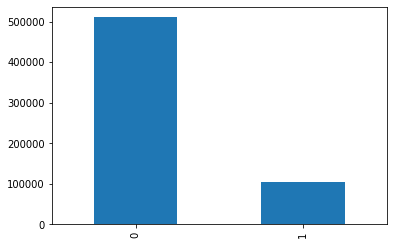

In [22]:
pd.Series(conflicts).value_counts().plot(kind='bar')

In [29]:
pd.Series(conflicts).value_counts()

0    510734
1    104693
dtype: int64

In [24]:
104693/len(data)

0.1701144083701235

In [25]:
len(data)

615427

In [26]:
data.head()

,ICD_CODE,ASCII_DESC,sdl_code,SDL_DESC,PORTAL_TRANS_ID,PORTAL_DATE,PROVIDER_ID,MEMBER_CODE,MEMBER_AGE,POLICY_NO,CLAIM_DATE,CLM_NET_AMT,labels
0,001,No Diagnosis,289565,Medicine,M51979416,2018-10-06 00:00:00,530990,002446163228002,NaN,14916448.0,2018-07-26,35.50,0
1,001,No Diagnosis,289565,Medicine,M51979482,2018-10-06 00:00:00,530990,001016816421101,NaN,14850894.0,2018-07-17,66.47,0
2,001,No Diagnosis,289565,Medicine,M52020162,2018-10-08 00:00:00,530990,001042368413001,NaN,1024.0,2018-07-25,71.21,0
3,A01,Typhoid and paratyphoid fevers,119,ADOL 500MG CAPLET,434855586,2018-10-02 20:48:25,550042,001025018266251,18.0,8900.0,2018-09-13,223.84,0
4,A01,Typhoid and paratyphoid fevers,179,Risek 20 mg capsul,437285538,2018-10-13 12:56:58,524611,002359688104202,2.0,14957670.0,2018-09-15,574.49,0


In [27]:
data['labels'] = pd.Series(conflicts)

In [31]:
data.labels.value_counts()

0    510734
1    104693
Name: labels, dtype: int64

In [32]:
data.to_csv('thread_806.csv')